# Code for downloading rainfall data from NOAA radar

##### Note: Install the rasterio module using the command line, "conda install rasterio"



In [360]:
# Import modules
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
#from rasterio import features as ft
from rasterio.warp import calculate_default_transform, reproject, Resampling


In [250]:
# Obtain the current working directory

glob.os.getcwd()


'C:\\Users\\parkernath32\\Dropbox\\Nathaniel Parker\\KSU_Coursework\\Spring 2020\\Introduction to Scientific Programming\\semester_project'

In [252]:
# User inputs

SOI = input('Enter station name')
lat_SOI = float(input('Enter latitude'))
lon_SOI = float(input('Enter longitude'))
interval = input('Enter data interval')
start =input('Enter start date in mm-dd-yyyy')
end =input('Enter end date in mm-dd-yyyy')
#email = input('Enter recipient email address')

Enter station name 
Enter latitude 39
Enter longitude -98
Enter data interval 
Enter start date in mm-dd-yyyy 
Enter end date in mm-dd-yyyy 


In [253]:
# Load the .csv file containing radar locations in Kansas

radar = pd.read_csv('radars.csv')

radar.head(13)
#radar.tail()

,Radar_station,State,Latitude,Longitude,Elevation,NEXRAD_ID,Start_date
0,Amarillo,TX,35.23333,-101.70889,1093.3,KAMA,8/4/1994
1,Denver Front Range Airport,CO,39.78667,-104.54528,1675.5,KFTG,5/9/1995
2,Des Moines,IA,41.73111,-93.72278,299.0,KDMX,5/9/1995
3,Dodge City,KS,37.76083,-99.96833,789.4,KDDC,1/1/1995
4,Fort Smith,AR,35.29056,-94.36167,NaN,KSRX,2/10/1997
5,Goodland,KS,39.36694,-101.70000,1112.8,KGLD,5/9/1995
6,Hastings,NE,40.32083,-98.44167,602.3,KUEX,4/11/1995
7,Kansas City,MO,38.81028,-94.26417,303.3,KEAX,5/9/1995
8,North Platte,NE,41.95778,-100.57583,905.3,KLNX,5/3/1996
9,Oklahoma City,OK,35.33306,-97.27750,369.7,KTLX,5/9/1995


In [314]:
# Creating a Haversine function for computing the distance between two points on the earth's surface

def haversine (lat1,lon1,lat2,lon2):
    " A Function for calculating the distance between two points on the earth's surface using the Haversine formula"
    
    import math
    
    R = 6371000  # radius of the earth in meters
    a = math.sin(math.radians((lat1-lat2)/2))**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(math.radians((lon1-lon2)/2))**2
    if a < 0:
        print('row',row,'col',col,':', 'Error: sqrt(a) is undefined, a is negative')
    else:
        b = 2* math.atan2(math.sqrt(a), math.sqrt(1-a))
        row_col = (row,col)
        d = round(R*b/1000,3) # converting the distance from m to km
        return d #,row_col
    


In [255]:
# Calculating the distances between the station of interest (SOI) and selecting the nearest distance

# Calculating the distance between the stations

distances = []
for i in range(len(radar)):
    distances.append(haversine(lat_SOI,lon_SOI,radar.Latitude[i],radar.Longitude[i]))



In [256]:
# Select the nearest radar station to SOI and its geographic coordinates

for i in range(len(distances)):
    if distances[i] == min(distances):
        idx_nearest = i
        nearest_distance = distances[i]
        nearest_name = radar.Radar_station[i]
        nearest_coordinates = [radar.Latitude[i], radar.Longitude[i]]
        

print('idx:',idx_nearest)
print('nearest distance:', nearest_distance,'km')
print('nearest radar:', nearest_name)
print('nearest station coordinates:',nearest_coordinates)


idx: 6
nearest distance: (151.657, (859, 1674)) km
nearest radar: Hastings
nearest station coordinates: [40.32083, -98.44167]


In [263]:
# RAINFALL CODE STARTS

In [264]:
# List of data files in the folder

data_files = [file for file in glob.glob("*conus.tif")]
data_files


['nws_precip_1hour_conus.tif',
 'nws_precip_last365days_20200426_conus.tif',
 'nws_precip_wytd_20191001_conus.tif',
 'nws_precip_ytd_20200101_conus.tif']

In [265]:
# Load a single file to explore the data information

data = rasterio.open(data_files[2])

print(data)

print(data.shape)
print(data.width)
print(data.height)
print(data.indexes)
print(data.bounds)
print(data.crs)


<open DatasetReader name='nws_precip_wytd_20191001_conus.tif' mode='r'>
(881, 1121)
1121
881
(1, 2, 3, 4)
BoundingBox(left=-1904912.11073866, bottom=-7619986.69569394, right=3434410.88926134, top=-3423783.69569394)
PROJCS["NOAA_HRAP_Grid",GEOGCS["GCS_NOAA_HRAP",DATUM["D_NOAA_HRAP",SPHEROID["Sphere",6371200,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


In [266]:
# Save columns and rows as well as values less than 0.

rows,cols = data.shape
idx_no_us = data.read(1) < 0
rows, cols
idx_no_us



array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [267]:
rainfall_3d = np.ones([rows,cols,len(data_files)]) * np.nan
rainfall_3d.shape

(881, 1121, 4)

In [268]:
# Create empty matrix

rainfall_3d = np.ones([rows,cols,len(data_files[1:2])]) * np.nan

# Iterate and append rainfall for each day to build a 3D array
for count,filename in enumerate(data_files[1:2]):
    data = rasterio.open(filename)
    print(count,data)
    rainfall = data.read(1)
    rainfall[idx_no_us] = np.nan
    rainfall_3d[:,:,count] = rainfall
#data

0 <open DatasetReader name='nws_precip_last365days_20200426_conus.tif' mode='r'>


In [302]:
# Inspect resulting 3D array

haversine(39.1836,-96.5717,39.1279,-96.6156)

(7.259, (859, 1674))

In [305]:
# Compute cumulative rainfall for each single pixel

cum_rainfall = np.nansum(rainfall_3d, axis=2)
cum_rainfall = cum_rainfall * 25.4 # inches to millimeters

cum_rainfall[859, 1674]


IndexError: index 1674 is out of bounds for axis 1 with size 1121

In [271]:
# Inspect dimensions and data within the cumulative sum

print(cum_rainfall.shape)
cum_rainfall[0:10,0:5]


(881, 1121)


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [310]:
# Set to `NaN` all the pixels that are outside the PRISM US boundaries and are equal to zero

cum_rainfall[idx_no_us | (cum_rainfall == 0)] = np.nan


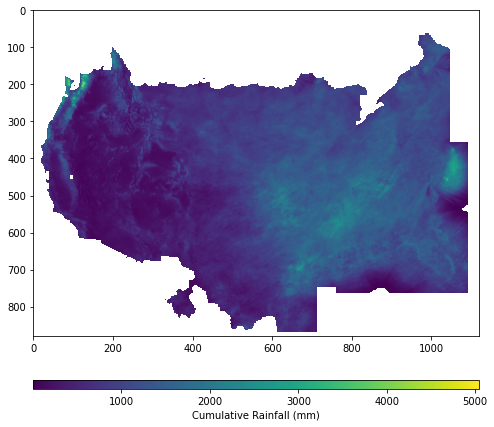

In [313]:
# Plot Map of cummulative rainfall

plt.figure(figsize=(8,8))
plt.imshow(cum_rainfall, aspect='auto')
plt.colorbar(orientation="horizontal", pad=0.1, aspect=50, label="Cumulative Rainfall (mm)")
#plt.scatter(859, 1674, marker='*', color='b', s=100)
plt.gca().axes.get_xaxis().set_visible(True)
plt.gca().axes.get_yaxis().set_visible(True)
plt.show()


In [274]:
# RAINFALL CODE
sx = rasterio.open(data_files[2]) 
sx.shape[1]
sx.crs

CRS.from_wkt('PROJCS["NOAA_HRAP_Grid",GEOGCS["GCS_NOAA_HRAP",DATUM["D_NOAA_HRAP",SPHEROID["Sphere",6371200,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]')

In [275]:
# Loop through data to extract Coordinates for each pixel

map_coords = []
for row in range(sx.shape[0]):    
    for col in range(sx.shape[1]):        
        map_coords.append(sx.xy(row,col, offset ='ul'))

map_coords[1:5]


[(-1900149.11073866, -3423783.69569394),
 (-1895386.11073866, -3423783.69569394),
 (-1890623.11073866, -3423783.69569394),
 (-1885860.11073866, -3423783.69569394)]

In [276]:
# A function to convert the coordinates reference system 

def reproject_et(inpath, outpath, new_crs):
    
    'A function to convert a raster from one coordinate system to another coordinate system. This function will load back into into python the new file created'
    'Definition of inputs: inpath = name of the file which is to be converted'
    'outpath = name of the new file after the conversion'  
    'new_crs = the new refrence system you want'
   
    dst_crs = new_crs # CRS for web meractor 

    with rasterio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
                

In [277]:
# Convert the data into the new coordinte system

new_crs = 'EPSG:4326'
inpath = data_files[2]
outpath = 'data_new.tif'
reproject_et(inpath,outpath,new_crs)

new_file = rasterio.open(outpath) # open the new file to python
new_file.crs
new_file.shape



In [278]:
# Extract the geographic coordinates

map_coords = []
for row in range(new_file.shape[0]):    
    for col in range(new_file.shape[1]):        
        map_coords.append(new_file.xy(row,col, offset ='ul'))

map_coords[3:5]


(860, 1675)

In [315]:
# Compute the distance between SOI and the varous coordinates

distances = []
for row in range(new_file.shape[0]):
    for col in range(new_file.shape[1]):
        distances.append(haversine(lat_SOI,lon_SOI,row,col))
        
        
       

row 501 col 82 : Error: sqrt(a) is undefined, a is negative
row 501 col 442 : Error: sqrt(a) is undefined, a is negative
row 501 col 802 : Error: sqrt(a) is undefined, a is negative
row 501 col 1162 : Error: sqrt(a) is undefined, a is negative
row 501 col 1522 : Error: sqrt(a) is undefined, a is negative


In [319]:
for i in range(len(distances)):
    if distances[i] == min(distances):
        idx_nearest = distances(i)
        nearest_distance = distances[i]
        #nearest_name = radar.Radar_station[i]
        nearest_coordinates = newfile.xy(row[i], col[i])
        

print('idx:',idx_nearest)
print('nearest distance:', nearest_distance,'km')
print('nearest radar:', nearest_name)
print('nearest station coordinates:',nearest_coordinates)


TypeError: '<' not supported between instances of 'NoneType' and 'float'

In [385]:
# Find the dimension of each pixel

height_spacing = (new_file.bounds.top - new_file.bounds.bottom)/new_file.height
print('height spacing: ',height_spacing,'degrees')

width_spacing = (new_file.bounds.right- new_file.bounds.left)/new_file.width
print('width spacing: ',width_spacing,'degrees')


height spacing:  0.044273720114906476 degrees
width spacing:  0.044273720114906476 degrees


In [388]:
# Find and create a mask for the missing data values 

nodata_value = new_file.nodata # find the missing data 

new_file_masked = np.ma.masked_equal(new_file.read(),nodata_value) # mask the missing data 

# data_masked[1,609,800] #[1,600,800]

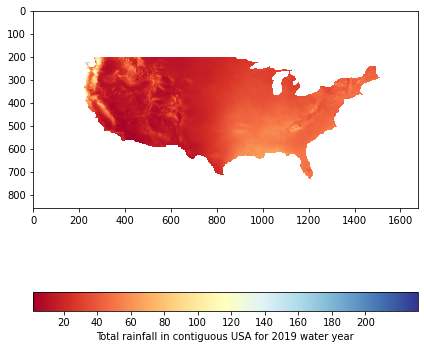

In [389]:
# Plot a map of the observed data without missing values

plt.figure(figsize= (6,8))
plt.imshow(new_file_masked[1,:,:], cmap = 'RdYlBu') #Band 1 contains the observed data

#plt.scatter(859, 1674, marker='*', color='b', s=100) 

cb = plt.colorbar(ticks = range(0,201,20), label = 'Total rainfall in contiguous USA for 2019 water year', orientation = 'horizontal')
plt.tight_layout()
#plt.savefig('ConUS_wyr')
plt.show()
